# Analyzing data from SUS

This notebook gathers data about the brazilian SUS system. The datasets are:
1. `ubs.csv`: Basic Healthcare Units - UBS (data from 2013, http://dados.gov.br/dataset/unidades-basicas-de-saude-ubs);
2. `internacoes.csv`: Hospitalization (data from 2011, http://dados.gov.br/dataset/wms_idsus_nt_prisab).

The main goal is to find regions that could benefit more from improved public healthcare.

First, those datasets headers were edited to be easier to work with. Also, extra data attached to the CSV (explanation texts, titles) were removed.

## Read data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Regex
import re

# Plotting
import matplotlib.pyplot as plt

# K-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from numpy.random import seed
seed(1)

SCATTER_SIZE=2
DEFAULT_FIGURE_SIZE=(12,12)

In [2]:
print(os.listdir("./"))

['analise-sus.ipynb', '.DS_Store', 'requirements.txt', 'ubs.csv', 'populacao.csv', '.ipynb_checkpoints', '.git', 'internacoes.csv']


In [3]:
raw_ubs = pd.read_csv('./ubs.csv')
raw_ubs.shape

(37690, 13)

In [4]:
hospitalizations = pd.read_csv('./internacoes.csv')
hospitalizations.shape

(5565, 3)

In [5]:
population_raw = pd.read_csv('./populacao.csv')
population_raw.shape

(5570, 2)

In [6]:
population_raw.head()

,dsc_cidade,populacao
0,Alta Floresta D'Oeste (RO),22728
1,Ariquemes (RO),109523
2,Cabixi (RO),5188
3,Cacoal (RO),85893
4,Cerejeiras (RO),16204


In [7]:
# Normalize data from population

# Splits city and state
population = population_raw['dsc_cidade'].str.extract('(?P<dsc_cidade>.*)\ \((?P<estado>[A-Z]{2})\)', expand=True)

population['populacao'] = population_raw["populacao"]

population.head()

,dsc_cidade,estado,populacao
0,Alta Floresta D'Oeste,RO,22728
1,Ariquemes,RO,109523
2,Cabixi,RO,5188
3,Cacoal,RO,85893
4,Cerejeiras,RO,16204


## Data Processing

In [8]:
X = 'vlr_longitude'
Y = 'vlr_latitude'

raw_ubs.head()

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos
0,-10.911237,-37.062078,280030,3492,US OSWALDO DE SOUZA,TV ADALTO BOTELHO,GETULIO VARGAS,Aracaju,7931791326,Desempenho acima da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média
1,-9.485943,-35.857573,270770,6685315,USF ENFERMEIRO PEDRO JACINTO AREA 09,R 15 DE AGOSTO,CENTRO,Rio Largo,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
2,-23.896000,-53.410000,411885,6811299,UNIDADE DE ATENCAO PRIMARIA SAUDE DA FAMILIA,RUA GUILHERME BRUXEL,CENTRO,Perobal,4436251462,Desempenho muito acima da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho muito acima da média
3,-16.447874,-41.009860,313580,6335616,POSTO DE SAUDE DE BOM JESUS DA ALDEIA,RUA TEOFILO OTONI,ALDEIA,Jequitinhonha,3337411423,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média
4,-6.573311,-35.107605,250930,6662226,POSTO ANCORA URUBA,RODOVIA PB N 065,SITIO,Mataraca,Não se aplica,Desempenho acima da média,Desempenho acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média


In [9]:
hospitalizations.head()

,dsc_cidade,nota,data_ref
0,Engenheiro Coelho,10.000000,2011-12-31
1,São José do Piauí,4.489151,2011-12-31
2,Jataí,9.005388,2011-12-31
3,Carolina,3.805439,2011-12-31
4,Abre Campo,5.862776,2011-12-31


In [10]:
population.head()

,dsc_cidade,estado,populacao
0,Alta Floresta D'Oeste,RO,22728
1,Ariquemes,RO,109523
2,Cabixi,RO,5188
3,Cacoal,RO,85893
4,Cerejeiras,RO,16204


In [11]:
ubs_with_quality = pd.merge(left=raw_ubs, right=hospitalizations, left_on='dsc_cidade', right_on='dsc_cidade')
ubs = pd.merge(left=ubs_with_quality, right=population, left_on='dsc_cidade', right_on='dsc_cidade')
ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao
0,-10.911237,-37.062078,280030,3492,US OSWALDO DE SOUZA,TV ADALTO BOTELHO,GETULIO VARGAS,Aracaju,7931791326,Desempenho acima da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média,10.000000,2011-12-31,SE,664908
1,-10.968969,-37.082076,280030,2291,US GERALDO MAGELA DE MENEZES SAO CONRADO,RUA CENTRAL 4,SAO CONRADO,Aracaju,7931791704,Desempenho muito acima da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média,10.000000,2011-12-31,SE,664908
2,-10.903630,-37.078986,280030,2542,US JOAO CARDOSO NASCIMENTO JUNIOR JOSE CONRADO...,RUA ALAGOAS,JOSE CONRADO DE ARAU,Aracaju,7931792261,Desempenho acima da média,Desempenho acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SE,664908
3,-10.959978,-37.078106,280030,2445,US HUMBERTO MOURAO GUIMARAES SAO CONRADO,RUA A,SAO CONRADO,Aracaju,7931791708,Desempenho mediano ou um pouco abaixo da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média,10.000000,2011-12-31,SE,664908
4,-10.894167,-37.079308,280030,2429,US JOSE MACHADO DE SOUZA SANTOS DUMONT,RUA MARECHAL AURELIANO,SANTOS DUMONT,Aracaju,7932457815,Desempenho muito acima da média,Desempenho acima da média,Desempenho muito acima da média,Desempenho acima da média,10.000000,2011-12-31,SE,664908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53310,-22.435992,-47.719803,352110,2785331,CENTRO DE SAUDE III IPEUNA,AVN TRES,CENTRO,Ipeúna,1935761224,Desempenho mediano ou um pouco abaixo da média,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SP,7687
53311,-29.422084,-51.515279,431935,2226154,POSTO DE SAUDE SAO PEDRO DA SERRA,AVENIDA DUQUE DE CAXIAS,CENTRO,São Pedro da Serra,5136451174,Desempenho muito acima da média,Desempenho mediano ou um pouco abaixo da média,Desempenho muito acima da média,Desempenho muito acima da média,10.000000,2011-12-31,RS,3842
53312,-22.661941,-52.864151,410710,2782820,NIS II DIAMANTE DO NORTE,RUA REYNALDO MASSI,CENTRO,Diamante do Norte,4434291442,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho acima da média,Desempenho muito acima da média,6.722952,2011-12-31,PR,5030
53313,-18.591056,-41.486349,316105,2102862,UNIDADE DE SAUDE SENHORA SEBASTIANA ROSA DE JESUS,RUA JUAREZ RIBEIRO PORTES,CENTRO,São Félix de Minas,(33)32469066,Desempenho acima da média,Desempenho muito acima da média,Desempenho acima da média,Desempenho muito acima da média,6.318068,2011-12-31,MG,3362


Here we plot the localization of the Basic Healthcare Units and the conditions of the UBS according to the parameters of the dataset. Each state is represented by a different color.

In [12]:
def figure_size():
    plt.figure(figsize=DEFAULT_FIGURE_SIZE)

def print_map(data, show=True, color=None, size=SCATTER_SIZE):
    if color == None:
        color = data['cor']
    
    if show:
        figure_size()
        
    plt.axis('equal')
    plt.scatter(data[X], data[Y], s=SCATTER_SIZE, alpha=0.5, c=color)
        
    if show:
        plt.show()

In [13]:
cmap = plt.get_cmap('viridis')
states = ubs['estado'].unique()
states.sort()

colors = cmap(np.linspace(0, 1, len(states)))
color_dict = dict(zip(states, colors))  

print(states)

['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']


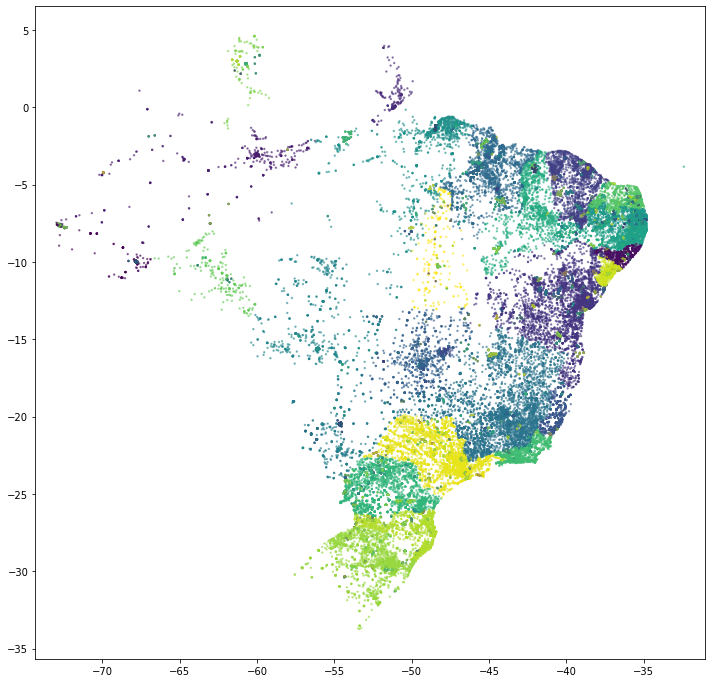

In [14]:
ubs['cor'] = ubs['estado'].apply(lambda x: color_dict[x])

print_map(ubs)

<AxesSubplot:>

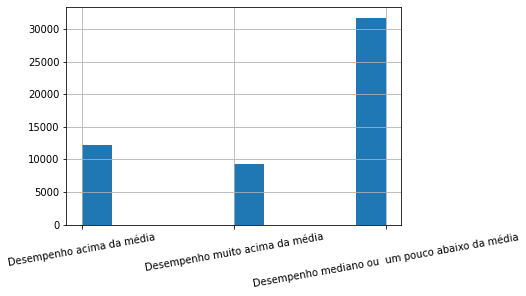

In [15]:
ubs['dsc_estrut_fisic_ambiencia'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

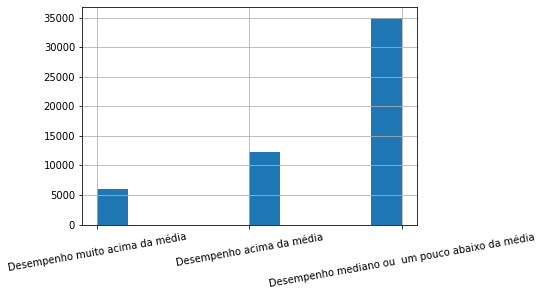

In [16]:
ubs['dsc_adap_defic_fisic_idosos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

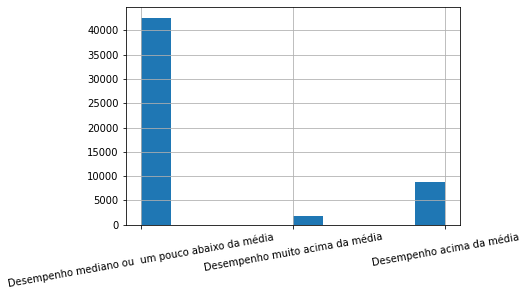

In [17]:
ubs['dsc_equipamentos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

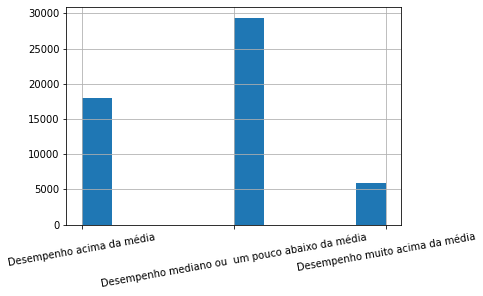

In [18]:
ubs['dsc_medicamentos'].hist(xlabelsize=10, xrot=10)

To make sure we are looking for the healthcare conditions in the worst regions, we select only the UBS with worst conditions in every parameter.

In [19]:
bad = "Desempenho mediano ou  um pouco abaixo da média"
bad_physical = ubs['dsc_estrut_fisic_ambiencia'] == bad
bad_elderly = ubs['dsc_adap_defic_fisic_idosos'] == bad
bad_equipment = ubs['dsc_equipamentos'] == bad
bad_medication = ubs['dsc_medicamentos'] == bad

generally_bad = bad_physical & bad_elderly & bad_equipment & bad_medication

selected_ubs = ubs[generally_bad]
selected_ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao,cor
20,-10.869931,-37.056541,280030,3603,US EUNICE BARBOSA DE OLIVEIRA,AV EUCLIDES FIGUEIREDO,COQUEIRAL,Aracaju,7931793415,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SE,664908,"[0.804182, 0.882046, 0.114965, 1.0]"
43,-9.485943,-35.857573,270770,6685315,USF ENFERMEIRO PEDRO JACINTO AREA 09,R 15 DE AGOSTO,CENTRO,Rio Largo,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.193679,2011-12-31,AL,75394,"[0.277941, 0.056324, 0.381191, 1.0]"
45,-9.452587,-35.849032,270770,2721554,USF DR GASTAO OITICICA,USINA SANTA CLOTILDE,ZONA RURAL,Rio Largo,8232618027,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.193679,2011-12-31,AL,75394,"[0.277941, 0.056324, 0.381191, 1.0]"
46,-9.525576,-35.797706,270770,2719843,USF PROF JOSE CARLOS DA SILVA,LOTEAMENTO PALMARES,TABDO PINTO,Rio Largo,8233524622,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.193679,2011-12-31,AL,75394,"[0.277941, 0.056324, 0.381191, 1.0]"
47,-9.529041,-35.799358,270770,2704986,USF BENEDITO LOPES,LOT PARQUE SANTA TEREZA,TABULEIRO DO PINTO,Rio Largo,33738173,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.193679,2011-12-31,AL,75394,"[0.277941, 0.056324, 0.381191, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53171,-28.269839,-49.760921,420250,2300974,UNIDADE SANITARIA MANTIQUEIRA,INTERIOR,MANTIQUEIRA,Bom Jardim da Serra,(49)2320195,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,7.554645,2011-12-31,SC,4772,"[0.699415, 0.867117, 0.175971, 1.0]"
53184,-21.072743,-48.410912,355365,2091909,UNIDADE BASICA DE SAUDE DE TAQUARAL CAETANO PI...,RUA CENTRAL,CENTRO,Taquaral,1639586195,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SP,2813,"[0.906311, 0.894855, 0.098125, 1.0]"
53212,-28.893335,-52.037237,430070,2251191,POSTO DE SAUDE DE ANTA GORDA,LINHA ITAPUCA,INTERIOR,Anta Gorda,5137561147,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,8.709950,2011-12-31,RS,5961,"[0.595839, 0.848717, 0.243329, 1.0]"
53226,-11.338159,-49.262867,170730,2467550,CENTRO DE SAUDE LUISA PINHEIRO BARROS DUERE,AVN JADER PIRES,CENTRO,Dueré,6333581180,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,5.385258,2011-12-31,TO,4686,"[0.993248, 0.906157, 0.143936, 1.0]"


In [20]:
bad_grade_ubs_count = ubs[ubs['nota'] >= 9.5].shape[0]
worst_ubs_count = selected_ubs[selected_ubs['nota'] >= 9.5].shape[0]

print('Total de UBSs: %d' % ubs.shape[0])
print('UBSs com nota maior que 9.5: %d' % bad_grade_ubs_count)
print('UBSs com infraestrutura de nota mínima em todas as 4 categorias: %d' % selected_ubs.shape[0])
print('UBSs com pior infraestrutura e nota maior que 9.5: %d' % worst_ubs_count)

print("\n===== Por Estado ====")
for state in states:
    state_ubs = ubs[ubs['estado'] == state]
    state_ubs_count = state_ubs.shape[0]
    mean = state_ubs['nota'].mean()
    std = state_ubs['nota'].std()
    print('UBSs no Estado do %s: %d (nota média: %0.1f±%0.1f)' % (state, state_ubs_count, mean, std))

Total de UBSs: 53315
UBSs com nota maior que 9.5: 18427
UBSs com infraestrutura de nota mínima em todas as 4 categorias: 15175
UBSs com pior infraestrutura e nota maior que 9.5: 4207

===== Por Estado ====
UBSs no Estado do AC: 292 (nota média: 7.4±1.8)
UBSs no Estado do AL: 1557 (nota média: 7.6±1.5)
UBSs no Estado do AM: 577 (nota média: 8.3±1.7)
UBSs no Estado do AP: 182 (nota média: 9.0±2.0)
UBSs no Estado do BA: 5042 (nota média: 7.0±1.8)
UBSs no Estado do CE: 2423 (nota média: 8.2±1.6)
UBSs no Estado do DF: 132 (nota média: 9.5±0.0)
UBSs no Estado do ES: 906 (nota média: 8.6±1.5)
UBSs no Estado do GO: 1584 (nota média: 7.9±1.5)
UBSs no Estado do MA: 2797 (nota média: 6.9±1.8)
UBSs no Estado do MG: 5876 (nota média: 8.3±1.6)
UBSs no Estado do MS: 830 (nota média: 7.7±1.7)
UBSs no Estado do MT: 967 (nota média: 8.2±1.8)
UBSs no Estado do PA: 1633 (nota média: 7.1±1.4)
UBSs no Estado do PB: 3446 (nota média: 7.7±1.7)
UBSs no Estado do PE: 2789 (nota média: 8.3±1.6)
UBSs no Estado do

In [21]:
ubs_space = selected_ubs.iloc[:,0:2]

Now that we know the worst ones, we plot a graph with them clusterized by region. We let

In [22]:
N_REGIONS = 26
kmeans = KMeans(n_clusters=N_REGIONS).fit(ubs_space)
        
centroids = kmeans.cluster_centers_

In [23]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, ubs_space)
closest

array([12041,  4101, 11071, 12175,  9711, 12851,  1523, 10710,  6423,
        5960, 11447,  7801,  5724,  5265,  6426, 11605, 14705, 11268,
        4317,  6531,  3315,   115, 13877,  4430,  2121,  6805])

### Map by clustering

In [24]:
ubs_space['cor'] = selected_ubs['cor']
ubs_space['dsc_cidade'] = selected_ubs['dsc_cidade']

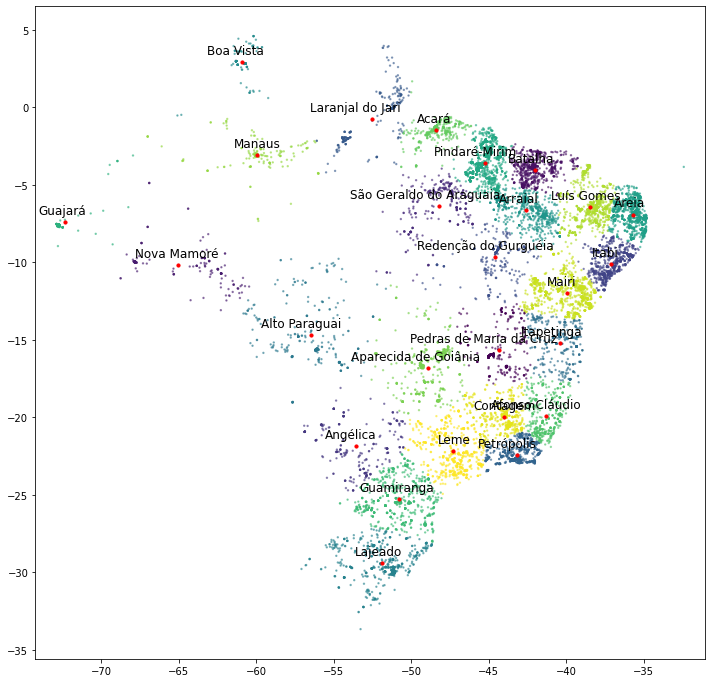

In [25]:
figure_size()
plt.axis('equal')
plt.scatter(ubs_space[X], ubs_space[Y], c= kmeans.labels_.astype(float), s=SCATTER_SIZE, alpha=0.5)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=10)

for i in range(len(centroids)):
    index = closest[i]
    city = ubs_space.iloc[index]['dsc_cidade']
    
    x = centroids[i, 1]-(0.25*len(city))
    y = centroids[i, 0]+0.5
    
    plt.text(x, y, city, fontsize=12)
    
plt.show()

###  Map by state

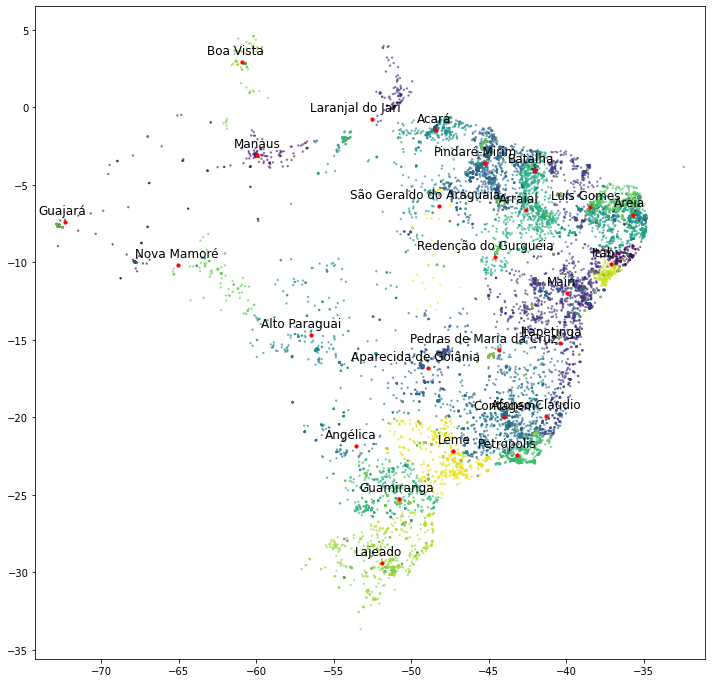

In [26]:
figure_size()
print_map(ubs_space, show=False)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=10)

for i in range(len(centroids)):
    index = closest[i]
    city = ubs_space.iloc[index]['dsc_cidade']
    
    x = centroids[i, 1]-(0.25*len(city))
    y = centroids[i, 0]+0.5
    
    plt.text(x, y, city, fontsize=12)

plt.show()

In [27]:
selected_ubs.iloc[closest]

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao,cor
40755,-15.612720,-44.388843,314915,6793223,UNIDADE BASICA DE SAUDE DONA QUITA PEREIRA,RUA SAFIRA,VILA MARIA,Pedras de Maria da Cruz,3892139676,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,7.418313,2011-12-31,MG,12212,"[0.169646, 0.456262, 0.55803, 1.0]"
13205,-4.051681,-42.007792,220150,2669021,PS LAGES,LAGES,ZONA RURAL,Batalha,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,5.060325,2011-12-31,PI,26905,"[0.146616, 0.67305, 0.508936, 1.0]"
37399,-10.404160,-65.334063,110033,2806940,CENTRO DE SAUDE PLANALTO NOVA MAMORE,AVENIDA CECILIA MEIRELES,CENTRO,Nova Mamoré,6935443194,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,5.619486,2011-12-31,RO,31392,"[0.404001, 0.800275, 0.362552, 1.0]"
41279,-6.400727,-48.555236,150745,2333341,UNIDADE DE SAUDE DA FAMILIA BEIRA RIO,TRAVESSA DO INCRA,BEIRA RIO,São Geraldo do Araguaia,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,6.198000,2011-12-31,PA,24705,"[0.127568, 0.566949, 0.550556, 1.0]"
32534,-22.152611,-53.768570,500085,2376628,PROGRAMA SAUDE DA FAMILIA DE ANGELICA,AVE PADRE AQUILINO FRANCISCHET,VILA ESPERANCA,Angélica,6734461563,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,5.214423,2011-12-31,MS,10932,"[0.154815, 0.493313, 0.55784, 1.0]"
43757,-10.087616,-37.139132,280310,2477785,PS POVOADO BOA HORA,POVOAD0,ZONA RURAL,Itabi,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,8.567123,2011-12-31,SE,4886,"[0.804182, 0.882046, 0.114965, 1.0]"
5439,-9.489237,-44.585309,220870,2404591,UNID DA FAMILIA DA PLANALTINA,RUA DO FERREIRO,PLANALTINA,Redenção do Gurguéia,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,5.799162,2011-12-31,PI,8796,"[0.146616, 0.67305, 0.508936, 1.0]"
36146,-0.840776,-52.521837,160027,4006496,PMLAJ UBS DR LELIO SILVA,AV EMILIO MEDICE,AGRESTE,Laranjal do Jari,9636212811,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,7.289705,2011-12-31,AP,51362,"[0.280868, 0.160771, 0.472899, 1.0]"
21482,-22.383689,-43.119450,330390,2275732,POSTO DE SAUDE DA LAJINHA,ESTRADA DAS ARCAS,ITAIPAVA,Petrópolis,22225196,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,RJ,306678,"[0.252899, 0.742211, 0.448284, 1.0]"
19557,-15.246223,-40.249035,291640,2510014,UBS FUNDACAO JUVINO OLIVEIRA,PCA DAYRI WALLEY,CENTRO,Itapetinga,(77) 2611257,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,7.919793,2011-12-31,BA,76795,"[0.271828,

Looking into this data, we realize that many of those UBS are in a rural area. This might be an insight for the future; a better primary care in these areas avoid issues related to moving pacients.

## Worst UBS in primary care

Here we filtered the UBS even further by choosing only the ones with really poor number of hospitalizations due o inefficient primary care (score of at least 9.5).

In [28]:
bad_primary = selected_ubs['nota'] >= 9.5
bad_primary_ubs = selected_ubs[bad_primary]

bad_primary_ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao,cor
20,-10.869931,-37.056541,280030,3603,US EUNICE BARBOSA DE OLIVEIRA,AV EUCLIDES FIGUEIREDO,COQUEIRAL,Aracaju,7931793415,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SE,664908,"[0.804182, 0.882046, 0.114965, 1.0]"
78,-7.037151,-37.288799,251080,6713971,UNIDADE DE SAUDE DA FAMILIA ANA RAQUEL,RUA SEVERINO SOARES,JD GUANABARA,Patos,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.538401,2011-12-31,PB,108192,"[0.120092, 0.600104, 0.54253, 1.0]"
79,-7.041324,-37.274466,251080,3480410,UNIDADE DE SAUDE DA FAMILIA DO MONTE CASTELO,RUA RENAN AYRES RIBEIRO DE BRITO,MONTE CASTELO,Patos,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.538401,2011-12-31,PB,108192,"[0.120092, 0.600104, 0.54253, 1.0]"
81,-7.054156,-37.276826,251080,3456366,UNIDADE DE SAUDE DA FAMILIA LAURO QUEIROZ,RUA JUSTINIANO GUEDES,JATOBA,Patos,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.538401,2011-12-31,PB,108192,"[0.120092, 0.600104, 0.54253, 1.0]"
82,-7.028697,-37.293370,251080,3456331,UNIDADE DE SAUDE DA FAMILIA PEDRO FIRMINO FILHO,PARQUE RESIDENCIAL SAO SEBASTIAO,LIBERDADE,Patos,Não se aplica,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,9.538401,2011-12-31,PB,108192,"[0.120092, 0.600104, 0.54253, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53139,-16.619010,-42.308049,311950,2134322,POSTO DE SAUDE BARRA DO SALINAS,C MURTA,C MURTA,Coronel Murta,33 37351284,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,MG,9215,"[0.169646, 0.456262, 0.55803, 1.0]"
53154,-18.073786,-43.478479,312010,2135337,CENTRO DE SAUDE DE COUTO MAGALHAES DE MINAS,RUA DO SITIO,CENTRO,Couto de Magalhães de Minas,3899793262,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,MG,4423,"[0.169646, 0.456262, 0.55803, 1.0]"
53162,-8.572115,-48.688102,171110,2560186,UNIDADE DE SAUDE DA FAMILIA ITAPORA,AVENIDA 15 DE NOVEMBRO,CENTRO,Itaporã do Tocantins,(63)34581104,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,TO,2420,"[0.993248, 0.906157, 0.143936, 1.0]"
53184,-21.072743,-48.410912,355365,2091909,UNIDADE BASICA DE SAUDE DE TAQUARAL CAETANO PI...,RUA CENTRAL,CENTRO,Taquaral,1639586195,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,Desempenho mediano ou um pouco abaixo da média,10.000000,2011-12-31,SP,2813,"[0.906311, 0.894855, 0.098125, 1.0]"


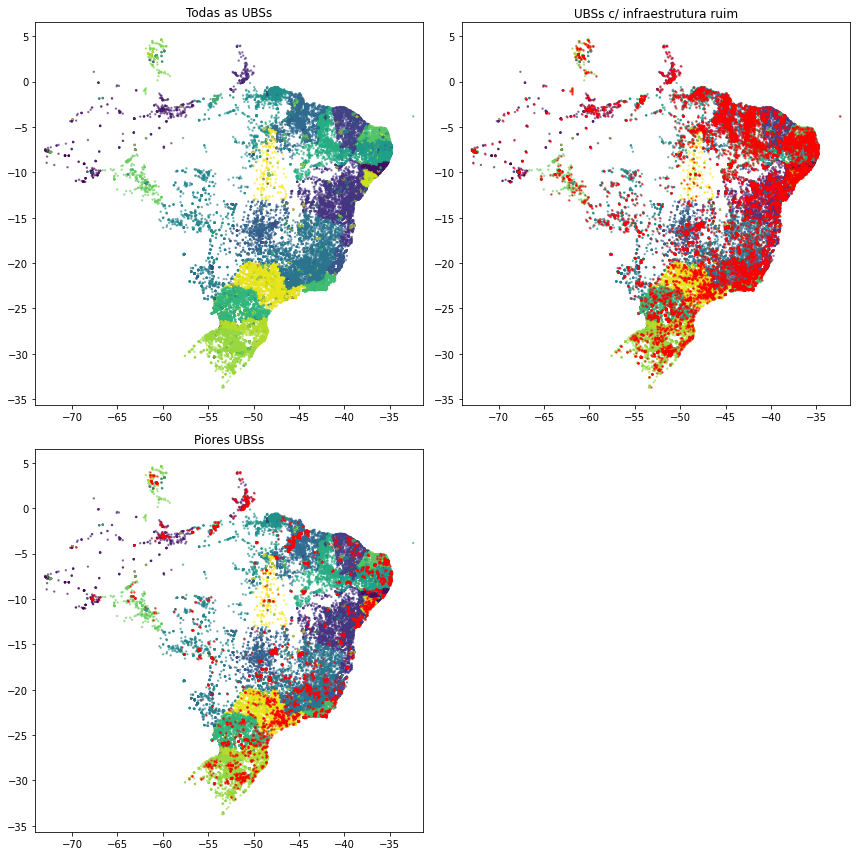

In [29]:
figure_size()

plt.subplot(2,2,1)
print_map(ubs, show=False, size=1)
plt.title('Todas as UBSs')

plt.subplot(2,2,2)
print_map(ubs, show=False, size=1)
print_map(ubs_space, show=False, color='red', size=1)
plt.title('UBSs c/ infraestrutura ruim')

plt.subplot(2,2,3)
print_map(ubs, show=False, size=1)
print_map(bad_primary_ubs, show=False, color='red', size=1)
plt.title('Piores UBSs')

plt.tight_layout()

Text(0.5, 1.0, 'UBSs de  pior qualidade por estado')

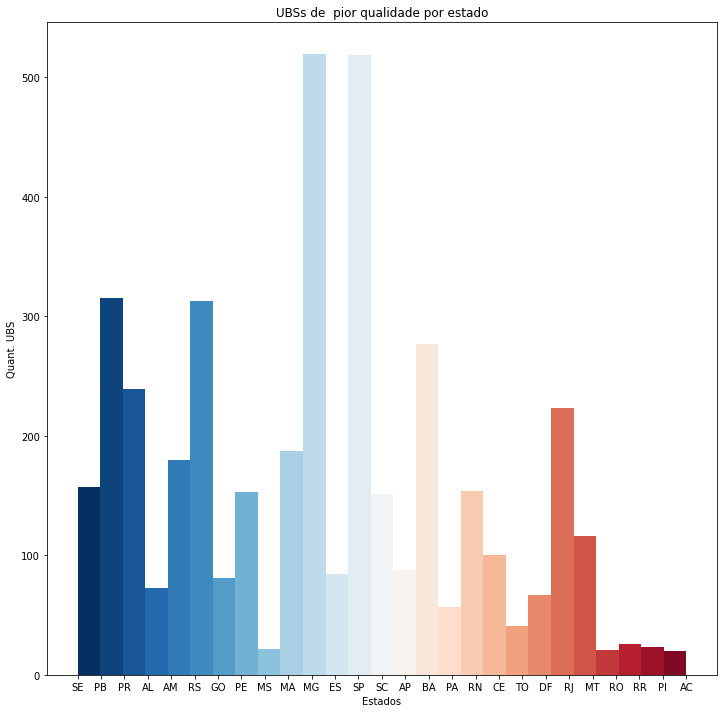

In [30]:
figure_size()
# bad_primary_ubs['estado'].hist(bins=len(states))

cm = plt.cm.RdBu_r

n, bins, patches = plt.hist(bad_primary_ubs['estado'], len(states), color='green')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(states))) # notice the i/25

plt.ylabel('Quant. UBS')
plt.xlabel('Estados')
plt.title('UBSs de  pior qualidade por estado')